# Early Prediction of Sepsis from Clinical Data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score,  accuracy_score, confusion_matrix
import xgboost as xgb
import pickle

## Load Data


In [4]:
train_data = pd.read_csv(f'/Users/ofrihefetz/PycharmProjects/lab2_hw1/data/train_df.csv')
test_data = pd.read_csv('/Users/ofrihefetz/PycharmProjects/lab2_hw1/data/test_df.csv')

# Data Preperations
In this part we will prepare the different forms of the data set, which we will examine over different models.

In [5]:
def data_prep(data):
    #  add a new column for each feature that indicates if the value is missing 0/1 values
    for col in data.columns:
        data[col + '_missing'] = data[col].isna().astype(int)
    return data

In [ ]:
def data_prep_2(data, agg_data):
    #  add a new column for each feature that indicated the % of missing values
    for col in data.columns.drop('filename'):
        missing_percentage_per_patient = data.groupby('filename')[col].apply(lambda x: (x.isnull().sum() / len(x)) * 100).reset_index()
        # print(missing_percentage_per_patient['filename'])
        agg_data=pd.merge(agg_data, missing_percentage_per_patient, on='filename')

        # agg_data[col + '_missing'] =missing_percentage_per_patient[1].astype(int)
    return agg_data

##  Train data sets


In [6]:
# ------------------------------------------------------------------------------------#
col_to_drop_new = ['SepsisPatient', 'SepsisPatient_missing', 'SepsisLabel', 'SepsisLabel_missing',
                   'filename_missing', 'filename']
col_to_drop = ['SepsisPatient', 'SepsisLabel', 'filename']
# ------------------------------------------------------------------------------------#
# original data no manipulation
train_data_x = train_data.copy().drop(col_to_drop, axis=1)
train_data_y = train_data['SepsisLabel']
# # ------------------------------------------------------------------------------------#
# original data with additional cols indicating for missing values per feature
train_data_new = data_prep(train_data)
train_data_new_x = train_data_new.drop(col_to_drop_new, axis=1)
train_data_new_y = train_data_new['SepsisLabel']
# # ------------------------------------------------------------------------------------#
# original data aggregated by the patient id (using median values)
train_data_agg_x = train_data.copy().groupby(by=['filename']).median()
train_data_agg_x = train_data_agg_x.drop(['SepsisPatient', 'SepsisLabel'], axis=1)
train_data_agg_y = train_data.groupby(by=['filename']).max()['SepsisPatient']
# # ------------------------------------------------------------------------------------#
# # data with additional cols aggregated  by the patient id (using median values)
train_data_new_agg_x = train_data_new.groupby(by=['filename']).median()
train_data_new_agg_x = train_data_new_agg_x.drop(
    ['SepsisPatient', 'SepsisPatient_missing', 'SepsisLabel', 'SepsisLabel_missing', 'filename_missing'], axis=1)
train_data_new_agg_y = train_data_new.groupby(by=['filename']).max()['SepsisPatient']
# # ------------------------------------------------------------------------------------#
# data with additional cols aggregated  by the patient id (using mean values)
train_data_added_agg_x = train_data_new.groupby(by=['filename']).mean()
train_data_added_agg_x = train_data_added_agg_x.drop(
    ['SepsisPatient', 'SepsisPatient_missing', 'SepsisLabel', 'SepsisLabel_missing', 'filename_missing'], axis=1)

# # ------------------------------------------------------------------------------------#
# data with additional cols aggregated  by the patient id (using mean+median values)
train_combined_data = train_data_added_agg_x.drop(['Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS'], axis=1)
train_combined_data = train_combined_data.add_prefix('mean')
train_combined_data_x = pd.concat([train_combined_data, train_data_new_agg_x], axis=1, join='inner')

# # ------------------------------------------------------------------------------------#
train=data_prep_2(train_data,train_data_agg_x)
train = train.drop('filename',axis=1)

## Test data sets

In [7]:
# ------------------------------------------------------------------------------------#
# original data no manipulation
test_data_x = test_data.drop(col_to_drop, axis=1)
test_data_y = test_data['SepsisLabel']
# # ------------------------------------------------------------------------------------#
# original data with additional cols indicating for missing values per feature
test_data_new = data_prep(test_data)
test_data_new_x = test_data_new.drop(col_to_drop_new, axis=1)
test_data_new_y = test_data_new['SepsisLabel']
# # ------------------------------------------------------------------------------------#
# original data aggregated by the patient id (using median values)
test_data_agg_x = test_data.groupby(by=['filename']).median()
test_data_agg_x = test_data_agg_x.drop(['SepsisPatient', 'SepsisLabel'], axis=1)
test_data_agg_y = test_data.groupby(by=['filename']).max()['SepsisPatient']
# # ------------------------------------------------------------------------------------#
# data with additional cols aggregated  by the patient id (using median values)
test_data_new_agg_x = test_data_new.groupby(by=['filename']).median()
test_data_new_agg_x = test_data_new_agg_x.drop(
    ['SepsisPatient', 'SepsisPatient_missing', 'SepsisLabel', 'SepsisLabel_missing', 'filename_missing'], axis=1)
test_data_new_agg_y = test_data_new.groupby(by=['filename']).max()['SepsisPatient']
# # ------------------------------------------------------------------------------------#
# data with additional cols aggregated  by the patient id (using mean values)
test_data_added_agg_x = test_data_new.groupby(by=['filename']).mean()
test_data_added_agg_x = test_data_added_agg_x.drop(
    ['SepsisPatient', 'SepsisPatient_missing', 'SepsisLabel', 'SepsisLabel_missing', 'filename_missing'], axis=1)

# ------------------------------------------------------------------------------------#
# data with additional cols aggregated  by the patient id (using mean+median values)
test_combined_data = test_data_added_agg_x.drop(['Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS'], axis=1)
test_combined_data = test_combined_data.add_prefix('mean')
test_combined_data_x = pd.concat([test_combined_data, test_data_new_agg_x], axis=1, join='inner')
# ------------------------------------------------------------------------------------
test=data_prep_2(test_data,test_data_agg_x)
test = test.drop('filename',axis=1)

# Methods
1. Logistic_Regression
2. Gaussian_Naive_Bayes_Classifier
3. XGBoost
4. DecisionTree

In [8]:
test_data_agg_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, patient_0.psv to patient_9999.psv
Data columns (total 83 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   HR                        9913 non-null   float64
 1   O2Sat                     9908 non-null   float64
 2   Temp                      9808 non-null   float64
 3   SBP                       9828 non-null   float64
 4   MAP                       9882 non-null   float64
 5   DBP                       8048 non-null   float64
 6   Resp                      9892 non-null   float64
 7   EtCO2                     771 non-null    float64
 8   BaseExcess                3143 non-null   float64
 9   HCO3                      4913 non-null   float64
 10  FiO2                      4259 non-null   float64
 11  pH                        4525 non-null   float64
 12  PaCO2                     4378 non-null   float64
 13  SaO2                      3126 non-null   f

In [7]:
def evaluation(y_test, predicted):
    accuracy_score(y_test, predicted)
    print(f"Accuracy is {accuracy_score(y_test, predicted)}")
    print(f"F1 score is {f1_score(y_test, predicted)}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, predicted))

## XGBoost

### initial test

In [8]:
def XGBoost(X_train, y_train, X_test, y_test):
    y_train = y_train.fillna(0)
    model_xgb = xgb.XGBClassifier(n_estimators=1000,booster='gbtree', objective='binary:logistic', eta=0.2, colsample_bytree=0.7)
    model_xgb.fit(X_train, y_train)
    y_pred_xgb = model_xgb.predict(X_test)
    evaluation(y_test, y_pred_xgb)

In [33]:
XGBoost(train_data_x,train_data_y,test_data_x,test_data_y)

Accuracy is 0.9979685989128975
F1 score is 0.005161290322580645
Confusion Matrix:
[[378768     32]
 [   739      2]]


In [34]:
XGBoost(train_data_new_x,train_data_new_y,test_data_new_x,test_data_new_y)

Accuracy is 0.9979290774909694
F1 score is 0.005063291139240506
Confusion Matrix:
[[378753     47]
 [   739      2]]


In [35]:
XGBoost(train_data_agg_x,train_data_agg_y,test_data_agg_x,test_data_agg_y)

Accuracy is 0.961
F1 score is 0.6829268292682927
Confusion Matrix:
[[9190   69]
 [ 321  420]]


In [36]:
XGBoost(train_data_new_agg_x,train_data_new_agg_y,test_data_new_agg_x,test_data_new_agg_y)

Accuracy is 0.9603
F1 score is 0.6753883892068684
Confusion Matrix:
[[9190   69]
 [ 328  413]]


### Fine tuning


In [39]:
def XGBoost_fine_t(X_train, y_train, X_test, y_test):
    model_xgb = xgb.XGBClassifier(n_estimators=1000, booster='gbtree', objective='binary:logistic', eta=0.03,max_depth=10, colsample_bytree=0.6,subsample=0.95)
    model_xgb.fit(X_train, y_train)
    y_pred_xgb = model_xgb.predict_proba(X_test)

    # set thresholds
    thresholds = np.linspace(0, 1, 10000)
    _F1 = [f1_score(y_test, 1 * (y_pred_xgb[:, 1] > th)) for th in thresholds]
    max_f1 = max(_F1)
    opt_th = thresholds[_F1.index(max_f1)]
    print(f'max f1 score is {max_f1}, when using {opt_th} as threshold ')

    # plotting the results
    plt.figure(figsize=(10, 5))
    plt.title('F1 score using different thresholds')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.scatter(thresholds, _F1, c='lightblue')
    plt.show()

    # # plotting feature importance
    # fig, ax = plt.subplots()
    # fig.set_size_inches(10,18)
    # xgb.plot_importance(model_xgb, ax)
    # plt.show()

max f1 score is 0.6949152542372882, when using 0.21532153215321534 as threshold 


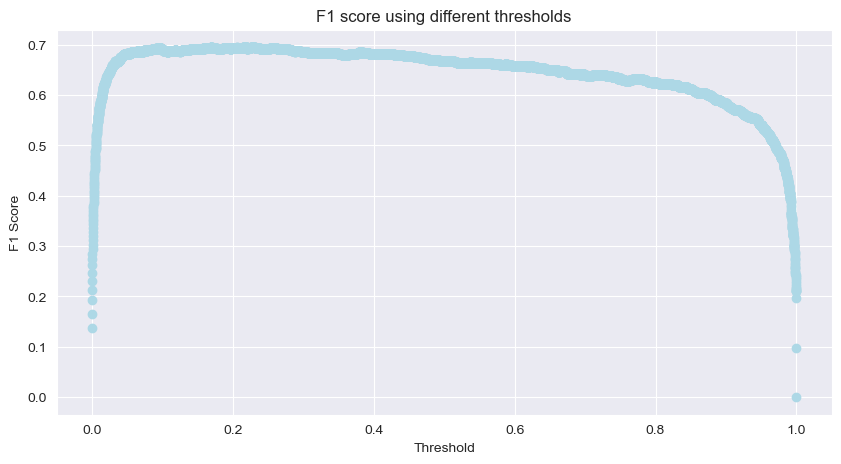

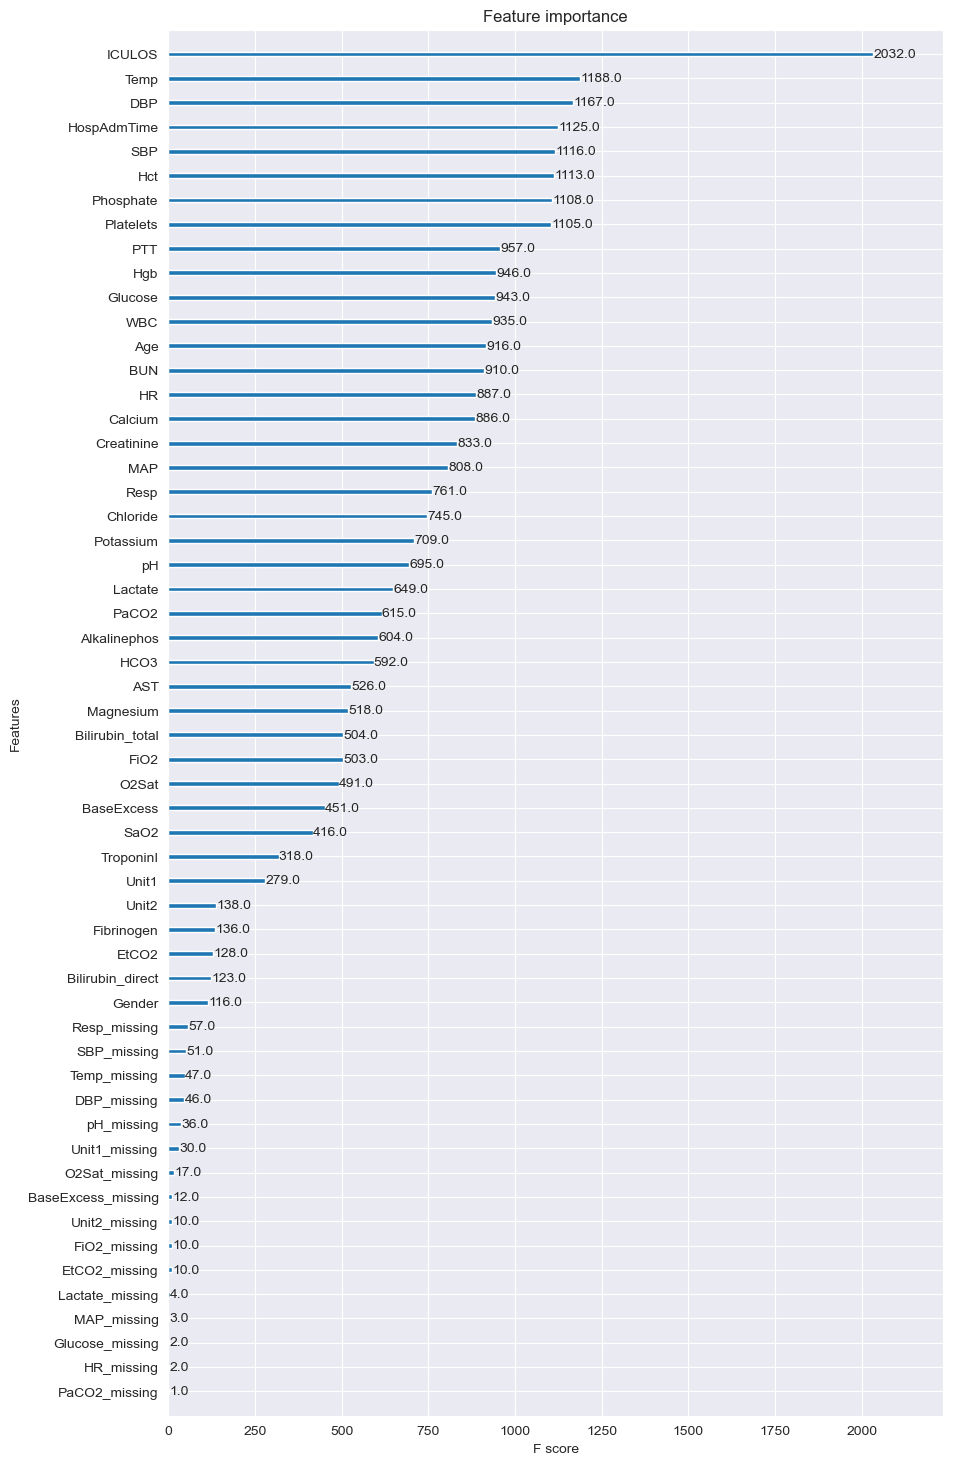

In [38]:
XGBoost_fine_t(train_data_agg_x,train_data_agg_y,test_data_agg_x,test_data_agg_y)

max f1 score is 0.7014581734458941, when using 0.20552055205520553 as threshold 


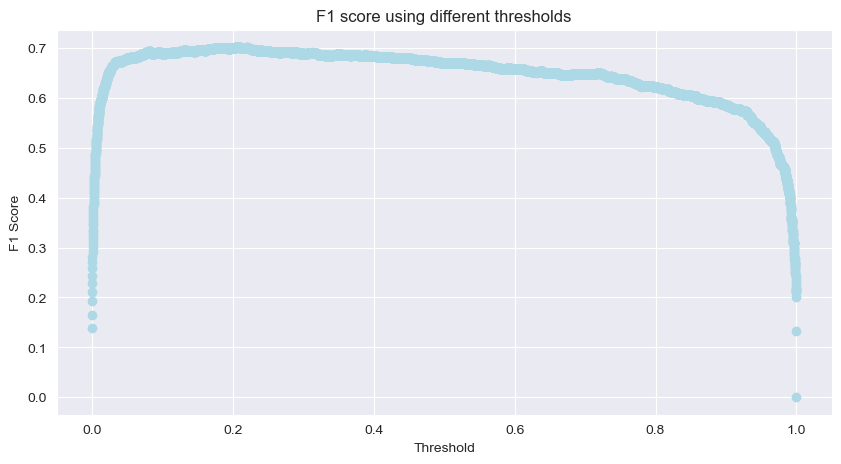

In [40]:
XGBoost_fine_t(train_data_new_agg_x,train_data_new_agg_y,test_data_new_agg_x,test_data_new_agg_y)

max f1 score is 0.710943396226415, when using 0.18951895189518952 as threshold 


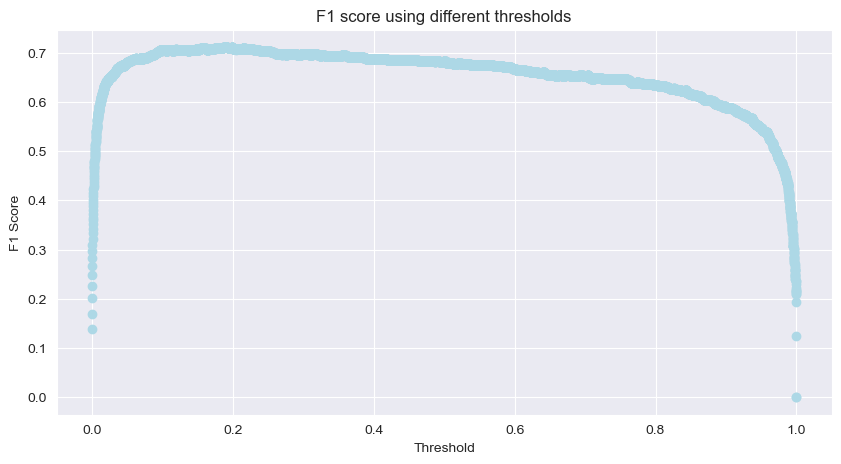

In [41]:
XGBoost_fine_t(train_data_added_agg_x,train_data_new_agg_y,test_data_added_agg_x,test_data_new_agg_y)

max f1 score is 0.7123695976154993, when using 0.19151915191519153 as threshold 


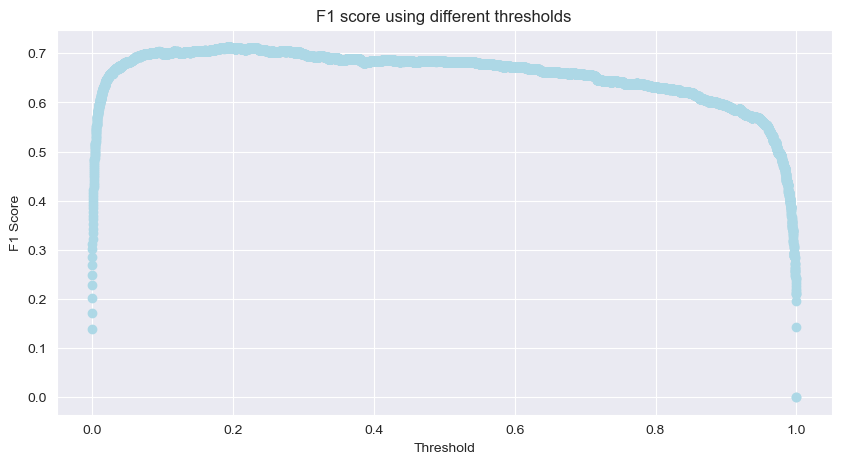

In [42]:
XGBoost_fine_t(train_combined_data_x,train_data_new_agg_y,test_combined_data_x,test_data_new_agg_y)

In [10]:
for m in range(1,11,1):
    model_xgb = xgb.XGBClassifier(n_estimators=1000, booster='gbtree', objective='binary:logistic', eta=0.6,max_depth=m, colsample_bytree=1,subsample=0.8)
    model_xgb.fit(train_combined_data_x, train_data_new_agg_y)
    y_pred_xgb = model_xgb.predict_proba(test_combined_data_x)

    # set thresholds
    thresholds = np.linspace(0, 1, 10000)
    _F1 = [f1_score(test_data_new_agg_y, 1 * (y_pred_xgb[:, 1] > th)) for th in thresholds]
    max_f1 = max(_F1)
    opt_th = thresholds[_F1.index(max_f1)]
    print(f"max_depth={m}")
    print(f'max f1 score is {max_f1}, when using {opt_th} as threshold ')

eta=1
max f1 score is 0.6566940912490651, when using 0.44134413441344134 as threshold 
eta=2
max f1 score is 0.6756960120391272, when using 0.30443044304430444 as threshold 
eta=3
max f1 score is 0.6682170542635659, when using 0.29122912291229125 as threshold 
eta=4
max f1 score is 0.6739446870451238, when using 0.13221322132213223 as threshold 
eta=5
max f1 score is 0.6793025018953753, when using 0.25712571257125716 as threshold 
eta=6
max f1 score is 0.6918518518518518, when using 0.15211521152115212 as threshold 
eta=7
max f1 score is 0.6843267108167771, when using 0.16111611161116113 as threshold 
eta=8
max f1 score is 0.6724137931034483, when using 0.34763476347634764 as threshold 
eta=9
max f1 score is 0.6946284032376748, when using 0.16601660166016602 as threshold 
eta=10
max f1 score is 0.690744920993228, when using 0.20722072207220724 as threshold 


In [11]:
for m in range(1,11,1):
    model_xgb = xgb.XGBClassifier(n_estimators=100, booster='gbtree', objective='binary:logistic', eta=0.6,max_depth=m, colsample_bytree=1,subsample=0.8)
    model_xgb.fit(train_combined_data_x, train_data_new_agg_y)
    y_pred_xgb = model_xgb.predict_proba(test_combined_data_x)

    # set thresholds
    thresholds = np.linspace(0, 1, 10000)
    _F1 = [f1_score(test_data_new_agg_y, 1 * (y_pred_xgb[:, 1] > th)) for th in thresholds]
    max_f1 = max(_F1)
    opt_th = thresholds[_F1.index(max_f1)]
    print(f"eta={m}")
    print(f'max f1 score is {max_f1}, when using {opt_th} as threshold ')

eta=1
max f1 score is 0.688548504741065, when using 0.34643464346434644 as threshold 
eta=2
max f1 score is 0.6745283018867925, when using 0.5303530353035304 as threshold 
eta=3
max f1 score is 0.6586921850079744, when using 0.5102510251025103 as threshold 
eta=4
max f1 score is 0.6789272030651341, when using 0.311031103110311 as threshold 
eta=5
max f1 score is 0.6847905951506246, when using 0.22112211221122113 as threshold 
eta=6
max f1 score is 0.6964951528709918, when using 0.21232123212321233 as threshold 
eta=7
max f1 score is 0.6845238095238095, when using 0.23872387238723874 as threshold 
eta=8
max f1 score is 0.673668417104276, when using 0.22392239223922392 as threshold 
eta=9
max f1 score is 0.6956521739130435, when using 0.23792379237923794 as threshold 
eta=10
max f1 score is 0.6894409937888198, when using 0.40174017401740175 as threshold 


In [12]:
for m in range(1,11,1):
    model_xgb = xgb.XGBClassifier(n_estimators=100, booster='gbtree', objective='binary:logistic', eta=0.6,max_depth=m, colsample_bytree=1,subsample=0.8,learning_rate=0.1)
    model_xgb.fit(train_combined_data_x, train_data_new_agg_y)
    y_pred_xgb = model_xgb.predict_proba(test_combined_data_x)

    # set thresholds
    thresholds = np.linspace(0, 1, 10000)
    _F1 = [f1_score(test_data_new_agg_y, 1 * (y_pred_xgb[:, 1] > th)) for th in thresholds]
    max_f1 = max(_F1)
    opt_th = thresholds[_F1.index(max_f1)]
    print(f"eta={m}")
    print(f'max f1 score is {max_f1}, when using {opt_th} as threshold ')

eta=1
max f1 score is 0.6880119136262101, when using 0.24632463246324635 as threshold 
eta=2
max f1 score is 0.7051094890510949, when using 0.25762576257625763 as threshold 
eta=3
max f1 score is 0.7092846270928462, when using 0.32603260326032607 as threshold 
eta=4
max f1 score is 0.7102661596958175, when using 0.32713271327132715 as threshold 
eta=5
max f1 score is 0.7066766691672919, when using 0.2905290529052905 as threshold 
eta=6
max f1 score is 0.7096296296296297, when using 0.24162416241624163 as threshold 
eta=7
max f1 score is 0.7004405286343611, when using 0.18871887188718872 as threshold 
eta=8
max f1 score is 0.706896551724138, when using 0.16211621162116213 as threshold 
eta=9
max f1 score is 0.7011070110701108, when using 0.19521952195219522 as threshold 
eta=10
max f1 score is 0.707787201233616, when using 0.29282928292829286 as threshold 


In [13]:
for m in range(1,11,1):
    model_xgb = xgb.XGBClassifier(n_estimators=100, booster='gbtree', objective='binary:logistic', eta=0.6,max_depth=m, colsample_bytree=1,subsample=0.85,learning_rate=0.095)
    model_xgb.fit(train_combined_data_x, train_data_new_agg_y)
    y_pred_xgb = model_xgb.predict_proba(test_combined_data_x)

    # set thresholds
    thresholds = np.linspace(0, 1, 10000)
    _F1 = [f1_score(test_data_new_agg_y, 1 * (y_pred_xgb[:, 1] > th)) for th in thresholds]
    max_f1 = max(_F1)
    opt_th = thresholds[_F1.index(max_f1)]
    print(f"eta={m}")
    print(f'max f1 score is {max_f1}, when using {opt_th} as threshold ')

eta=1
max f1 score is 0.6865671641791044, when using 0.23922392239223922 as threshold 
eta=2
max f1 score is 0.7092605886575736, when using 0.22972297229722974 as threshold 
eta=3
max f1 score is 0.7105847520355293, when using 0.30983098309830986 as threshold 
eta=4
max f1 score is 0.7069351230425056, when using 0.30013001300130016 as threshold 
eta=5
max f1 score is 0.7017024426350851, when using 0.26382638263826386 as threshold 
eta=6
max f1 score is 0.7061469265367316, when using 0.26632663266326634 as threshold 
eta=7
max f1 score is 0.6978527607361963, when using 0.27282728272827284 as threshold 
eta=8
max f1 score is 0.7025796661608498, when using 0.24992499249924993 as threshold 
eta=9
max f1 score is 0.7098214285714285, when using 0.21632163216321632 as threshold 
eta=10
max f1 score is 0.7058823529411766, when using 0.20732073207320734 as threshold 


In [14]:
for m in range(1,11,1):
    model_xgb = xgb.XGBClassifier(n_estimators=100, booster='gbtree', objective='binary:logistic', eta=0.6,max_depth=m, colsample_bytree=1,subsample=0.85,learning_rate=0.09)
    model_xgb.fit(train_combined_data_x, train_data_new_agg_y)
    y_pred_xgb = model_xgb.predict_proba(test_combined_data_x)

    # set thresholds
    thresholds = np.linspace(0, 1, 10000)
    _F1 = [f1_score(test_data_new_agg_y, 1 * (y_pred_xgb[:, 1] > th)) for th in thresholds]
    max_f1 = max(_F1)
    opt_th = thresholds[_F1.index(max_f1)]
    print(f"eta={m}")
    print(f'max f1 score is {max_f1}, when using {opt_th} as threshold ')

eta=1
max f1 score is 0.6824067022086824, when using 0.28042804280428046 as threshold 
eta=2
max f1 score is 0.7089167280766397, when using 0.27132713271327136 as threshold 
eta=3
max f1 score is 0.7114093959731542, when using 0.29892989298929895 as threshold 
eta=4
max f1 score is 0.7081770442610653, when using 0.30293029302930297 as threshold 
eta=5
max f1 score is 0.7106446776611695, when using 0.29972997299729975 as threshold 
eta=6
max f1 score is 0.7081770442610653, when using 0.28902890289028904 as threshold 
eta=7
max f1 score is 0.7066569129480614, when using 0.21192119211921193 as threshold 
eta=8
max f1 score is 0.7067557535263549, when using 0.21882188218821882 as threshold 
eta=9
max f1 score is 0.7083015993907082, when using 0.25742574257425743 as threshold 
eta=10
max f1 score is 0.7055350553505536, when using 0.19101910191019103 as threshold 


In [15]:
for m in range(1,11,1):
    model_xgb = xgb.XGBClassifier(n_estimators=100, booster='gbtree', objective='binary:logistic', eta=0.6,max_depth=m, colsample_bytree=1,subsample=0.85,learning_rate=0.089)
    model_xgb.fit(train_combined_data_x, train_data_new_agg_y)
    y_pred_xgb = model_xgb.predict_proba(test_combined_data_x)

    # set thresholds
    thresholds = np.linspace(0, 1, 10000)
    _F1 = [f1_score(test_data_new_agg_y, 1 * (y_pred_xgb[:, 1] > th)) for th in thresholds]
    max_f1 = max(_F1)
    opt_th = thresholds[_F1.index(max_f1)]
    print(f"eta={m}")
    print(f'max f1 score is {max_f1}, when using {opt_th} as threshold ')

eta=1
max f1 score is 0.6845637583892618, when using 0.23212321232123212 as threshold 
eta=2
max f1 score is 0.7130434782608696, when using 0.24762476247624762 as threshold 
eta=3
max f1 score is 0.7090909090909091, when using 0.34843484348434844 as threshold 
eta=4
max f1 score is 0.7091043671354552, when using 0.284028402840284 as threshold 
eta=5
max f1 score is 0.708649468892261, when using 0.32513251325132514 as threshold 
eta=6
max f1 score is 0.7040358744394618, when using 0.26692669266926694 as threshold 
eta=7
max f1 score is 0.7048458149779736, when using 0.20362036203620362 as threshold 
eta=8
max f1 score is 0.7093451066961001, when using 0.20252025202520252 as threshold 
eta=9
max f1 score is 0.712490761271249, when using 0.19911991199119913 as threshold 
eta=10
max f1 score is 0.7070254110612855, when using 0.22232223222322234 as threshold 


In [16]:
for m in range(1,11,1):
    model_xgb = xgb.XGBClassifier(n_estimators=100, booster='gbtree', objective='binary:logistic', eta=0.6,max_depth=m, colsample_bytree=1,subsample=0.85,learning_rate=0.085)
    model_xgb.fit(train_combined_data_x, train_data_new_agg_y)
    y_pred_xgb = model_xgb.predict_proba(test_combined_data_x)

    # set thresholds
    thresholds = np.linspace(0, 1, 10000)
    _F1 = [f1_score(test_data_new_agg_y, 1 * (y_pred_xgb[:, 1] > th)) for th in thresholds]
    max_f1 = max(_F1)
    opt_th = thresholds[_F1.index(max_f1)]
    print(f"eta={m}")
    print(f'max f1 score is {max_f1}, when using {opt_th} as threshold ')

eta=1
max f1 score is 0.684053651266766, when using 0.22762276227622763 as threshold 
eta=2
max f1 score is 0.7084870848708487, when using 0.27252725272527256 as threshold 
eta=3
max f1 score is 0.7193916349809887, when using 0.33913391339133914 as threshold 
eta=4
max f1 score is 0.7121879588839942, when using 0.25692569256925696 as threshold 
eta=5
max f1 score is 0.7087087087087087, when using 0.28792879287928796 as threshold 
eta=6
max f1 score is 0.7026615969581749, when using 0.29402940294029406 as threshold 
eta=7
max f1 score is 0.7043286867204696, when using 0.19891989198919893 as threshold 
eta=8
max f1 score is 0.7122884473877851, when using 0.21022102210221022 as threshold 
eta=9
max f1 score is 0.709251101321586, when using 0.20672067206720673 as threshold 
eta=10
max f1 score is 0.6987951807228916, when using 0.24662466246624662 as threshold 


In [17]:
for m in range(1,11,1):
    model_xgb = xgb.XGBClassifier(n_estimators=100, booster='gbtree', objective='binary:logistic', eta=0.6,max_depth=m, colsample_bytree=1,subsample=0.9,learning_rate=0.08)
    model_xgb.fit(train_combined_data_x, train_data_new_agg_y)
    y_pred_xgb = model_xgb.predict_proba(test_combined_data_x)

    # set thresholds
    thresholds = np.linspace(0, 1, 10000)
    _F1 = [f1_score(test_data_new_agg_y, 1 * (y_pred_xgb[:, 1] > th)) for th in thresholds]
    max_f1 = max(_F1)
    opt_th = thresholds[_F1.index(max_f1)]
    print(f"eta={m}")
    print(f'max f1 score is {max_f1}, when using {opt_th} as threshold ')

eta=1
max f1 score is 0.682089552238806, when using 0.22702270227022703 as threshold 
eta=2
max f1 score is 0.7039764359351989, when using 0.25962596259625964 as threshold 
eta=3
max f1 score is 0.710077519379845, when using 0.36893689368936894 as threshold 
eta=4
max f1 score is 0.7103746397694525, when using 0.23422342234223423 as threshold 
eta=5
max f1 score is 0.6985789080029917, when using 0.2903290329032903 as threshold 
eta=6
max f1 score is 0.7041036717062635, when using 0.19551955195519552 as threshold 
eta=7
max f1 score is 0.7057960381511373, when using 0.20912091209120912 as threshold 
eta=8
max f1 score is 0.7021121631463948, when using 0.19051905190519053 as threshold 
eta=9
max f1 score is 0.7121212121212122, when using 0.2633263326332633 as threshold 
eta=10
max f1 score is 0.710308502633559, when using 0.22812281228122813 as threshold 


In [18]:
for m in range(1,11,1):
    model_xgb = xgb.XGBClassifier(n_estimators=100, booster='gbtree', objective='binary:logistic', eta=0.6,max_depth=m, colsample_bytree=1,subsample=0.91,learning_rate=0.081)
    model_xgb.fit(train_combined_data_x, train_data_new_agg_y)
    y_pred_xgb = model_xgb.predict_proba(test_combined_data_x)

    # set thresholds
    thresholds = np.linspace(0, 1, 10000)
    _F1 = [f1_score(test_data_new_agg_y, 1 * (y_pred_xgb[:, 1] > th)) for th in thresholds]
    max_f1 = max(_F1)
    opt_th = thresholds[_F1.index(max_f1)]
    print(f"eta={m}")
    print(f'max f1 score is {max_f1}, when using {opt_th} as threshold ')

eta=1
max f1 score is 0.6844512195121951, when using 0.27722772277227725 as threshold 
eta=2
max f1 score is 0.7059690493736183, when using 0.26552655265526554 as threshold 
eta=3
max f1 score is 0.7112781954887218, when using 0.32913291329132915 as threshold 
eta=4
max f1 score is 0.7068100358422938, when using 0.22952295229522954 as threshold 
eta=5
max f1 score is 0.7032306536438768, when using 0.29402940294029406 as threshold 
eta=6
max f1 score is 0.7058823529411766, when using 0.24882488248824883 as threshold 
eta=7
max f1 score is 0.7026637868970482, when using 0.18941894189418942 as threshold 
eta=8
max f1 score is 0.6969696969696969, when using 0.17751775177517753 as threshold 
eta=9
max f1 score is 0.7035175879396984, when using 0.16901690169016903 as threshold 
eta=10
max f1 score is 0.7098248286367099, when using 0.26452645264526453 as threshold 


In [30]:
for m in range(1,11,1):
    model_xgb = xgb.XGBClassifier(n_estimators=600, booster='gbtree', objective='binary:logistic', eta=0.6,max_depth=m, colsample_bytree=1,subsample=0.91,learning_rate=0.081)
    model_xgb.fit(train_combined_data_x, train_data_new_agg_y)
    y_pred_xgb = model_xgb.predict_proba(test_combined_data_x)

    # set thresholds
    thresholds = np.linspace(0, 1, 10000)
    _F1 = [f1_score(test_data_new_agg_y, 1 * (y_pred_xgb[:, 1] > th)) for th in thresholds]
    max_f1 = max(_F1)
    opt_th = thresholds[_F1.index(max_f1)]
    print(f"eta={m}")
    print(f'max f1 score is {max_f1}, when using {opt_th} as threshold ')

eta=1
max f1 score is 0.7063197026022304, when using 0.33263326332633264 as threshold 
eta=2
max f1 score is 0.7077625570776256, when using 0.38223822382238226 as threshold 
eta=3
max f1 score is 0.7069625095638868, when using 0.3365336533653365 as threshold 
eta=4
max f1 score is 0.7085889570552149, when using 0.29262926292629265 as threshold 
eta=5
max f1 score is 0.7134052388289677, when using 0.29362936293629366 as threshold 
eta=6
max f1 score is 0.7085463842220598, when using 0.15431543154315433 as threshold 
eta=7
max f1 score is 0.7093889716840535, when using 0.18421842184218423 as threshold 
eta=8
max f1 score is 0.7051851851851852, when using 0.16841684168416843 as threshold 
eta=9
max f1 score is 0.7069486404833837, when using 0.22242224222422244 as threshold 
eta=10
max f1 score is 0.7099236641221375, when using 0.2518251825182518 as threshold 


In [27]:
for m in range(1,11,1):
    model_xgb = xgb.XGBClassifier(n_estimators=200, booster='gbtree', objective='binary:logistic', eta=0.6,max_depth=m, colsample_bytree=0.8,subsample=0.91,learning_rate=0.09,reg_alpha=0.01, reg_lambda=0.05,)
    model_xgb.fit(train_combined_data_x, train_data_new_agg_y)
    y_pred_xgb = model_xgb.predict_proba(test_combined_data_x)

    # set thresholds
    thresholds = np.linspace(0, 1, 10000)
    _F1 = [f1_score(test_data_new_agg_y, 1 * (y_pred_xgb[:, 1] > th)) for th in thresholds]
    max_f1 = max(_F1)
    opt_th = thresholds[_F1.index(max_f1)]
    print(f"eta={m}")
    print(f'max f1 score is {max_f1}, when using {opt_th} as threshold ')

eta=1
max f1 score is 0.6962209302325582, when using 0.22752275227522753 as threshold 
eta=2
max f1 score is 0.7119155354449472, when using 0.34133413341334135 as threshold 
eta=3
max f1 score is 0.7017804154302671, when using 0.3191319131913191 as threshold 
eta=4
max f1 score is 0.7040971168437026, when using 0.29542954295429547 as threshold 
eta=5
max f1 score is 0.7034082668600435, when using 0.18531853185318534 as threshold 
eta=6
max f1 score is 0.6986301369863014, when using 0.28062806280628066 as threshold 
eta=7
max f1 score is 0.701834862385321, when using 0.2684268426842684 as threshold 
eta=8
max f1 score is 0.7060653188180405, when using 0.30213021302130216 as threshold 
eta=9
max f1 score is 0.7067901234567902, when using 0.2678267826782678 as threshold 
eta=10
max f1 score is 0.7029411764705882, when using 0.15071507150715072 as threshold 


In [29]:
############# this is
for m in range(1,11,1):
    model_xgb = xgb.XGBClassifier(n_estimators=400, booster='gbtree', objective='binary:logistic', eta=0.6,max_depth=m, colsample_bytree=0.8,subsample=0.91,learning_rate=0.09,reg_alpha=0.01, reg_lambda=0.05,)
    model_xgb.fit(train_data_added_agg_x, train_data_new_agg_y)
    y_pred_xgb = model_xgb.predict_proba(test_data_added_agg_x)

    # set thresholds
    thresholds = np.linspace(0, 1, 10000)
    _F1 = [f1_score(test_data_new_agg_y, 1 * (y_pred_xgb[:, 1] > th)) for th in thresholds]
    max_f1 = max(_F1)
    opt_th = thresholds[_F1.index(max_f1)]
    print(f"eta={m}")
    print(f'max f1 score is {max_f1}, when using {opt_th} as threshold ')

eta=1
max f1 score is 0.7087087087087087, when using 0.33373337333733377 as threshold 
eta=2
max f1 score is 0.7140695915279879, when using 0.35553555355535554 as threshold 
eta=3
max f1 score is 0.7073359073359072, when using 0.33643364336433645 as threshold 
eta=4
max f1 score is 0.7136498516320475, when using 0.21082108210821082 as threshold 
eta=5
max f1 score is 0.7058823529411765, when using 0.3132313231323132 as threshold 
eta=6
max f1 score is 0.706408345752608, when using 0.18101810181018102 as threshold 
eta=7
max f1 score is 0.7115531752104055, when using 0.2605260526052605 as threshold 
eta=8
max f1 score is 0.706235912847483, when using 0.20592059205920593 as threshold 
eta=9
max f1 score is 0.7107806691449814, when using 0.1493149314931493 as threshold 
eta=10
max f1 score is 0.7057926829268293, when using 0.22292229222922294 as threshold 


In [32]:
for m in range(1,11,1):
    model_xgb = xgb.XGBClassifier(n_estimators=100, booster='gbtree', objective='binary:logistic', eta=0.6,max_depth=m, colsample_bytree=0.8,subsample=0.91,learning_rate=0.09,reg_alpha=0.01, reg_lambda=0.05,)
    model_xgb.fit(train_data_new_agg_x, train_data_new_agg_y)
    y_pred_xgb = model_xgb.predict_proba(test_data_new_agg_x)

    # set thresholds
    thresholds = np.linspace(0, 1, 10000)
    _F1 = [f1_score(test_data_new_agg_y, 1 * (y_pred_xgb[:, 1] > th)) for th in thresholds]
    max_f1 = max(_F1)
    opt_th = thresholds[_F1.index(max_f1)]
    print(f"eta={m}")
    print(f'max f1 score is {max_f1}, when using {opt_th} as threshold ')

eta=9
max f1 score is 0.6967644845748683, when using 0.16871687168716873 as threshold 
eta=10
max f1 score is 0.700077101002313, when using 0.19011901190119013 as threshold 
eta=1
max f1 score is 0.6821589205397302, when using 0.23292329232923292 as threshold 
eta=2
max f1 score is 0.6996309963099632, when using 0.24792479247924792 as threshold 
eta=3
max f1 score is 0.6992700729927007, when using 0.25532553255325535 as threshold 
eta=4
max f1 score is 0.6985789080029917, when using 0.28232823282328234 as threshold 
eta=5
max f1 score is 0.7057034220532319, when using 0.27782778277827785 as threshold 
eta=6
max f1 score is 0.6956521739130435, when using 0.24762476247624762 as threshold 
eta=7
max f1 score is 0.6937151949085123, when using 0.33693369336933693 as threshold 
eta=8
max f1 score is 0.6970889063729346, when using 0.28072807280728074 as threshold 
eta=9
max f1 score is 0.697301239970824, when using 0.1266126612661266 as threshold 
eta=10
max f1 score is 0.6999255398361877, wh

In [44]:
for m in range(1,11,1):
    model_xgb = xgb.XGBClassifier(n_estimators=1000, booster='gbtree', max_depth=m, colsample_bytree=1, reg_lambda=1000,)
    model_xgb.fit(train_data_added_agg_x, train_data_new_agg_y)
    y_pred_xgb = model_xgb.predict_proba(test_data_added_agg_x)

    # set thresholds
    thresholds = np.linspace(0, 1, 10000)
    _F1 = [f1_score(test_data_new_agg_y, 1 * (y_pred_xgb[:, 1] > th)) for th in thresholds]
    max_f1 = max(_F1)
    opt_th = thresholds[_F1.index(max_f1)]
    print(f"eta={m}")
    print(f'max f1 score is {max_f1}, when using {opt_th} as threshold ')

eta=1
max f1 score is 0.6893995552260934, when using 0.2832283228322832 as threshold 
eta=2
max f1 score is 0.7009841029523088, when using 0.358035803580358 as threshold 
eta=3
max f1 score is 0.7058823529411766, when using 0.3343334333433343 as threshold 
eta=4
max f1 score is 0.6997776130467012, when using 0.31533153315331536 as threshold 
eta=5
max f1 score is 0.7037037037037038, when using 0.24182418241824183 as threshold 
eta=6
max f1 score is 0.7011834319526628, when using 0.30723072307230725 as threshold 
eta=7
max f1 score is 0.7050359712230216, when using 0.25252525252525254 as threshold 
eta=8
max f1 score is 0.7061371841155235, when using 0.25762576257625763 as threshold 
eta=9
max f1 score is 0.7045291157440691, when using 0.25622562256225623 as threshold 
eta=10
max f1 score is 0.7043931496649293, when using 0.30763076307630766 as threshold 


In [48]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso

# Create a Lasso object with a regularization parameter of 0.1
lasso = Lasso(alpha=0.1)

# Create a SelectFromModel object using Lasso as the model
selector = SelectFromModel(lasso)

# Fit the selector to your training data
selector.fit(train_combined_data_x.fillna(-1), train_data_new_agg_y.fillna(0))

# Transform your training data using the selector
train_combined_data_x_lasso = selector.transform(train_combined_data_x.fillna(-1))

# Transform your test data using the selector
test_combined_data_x_lasso = selector.transform(test_combined_data_x.fillna(-1))


In [49]:
for m in range(1,11,1):
    model_xgb = xgb.XGBClassifier(n_estimators=1000, booster='gbtree', max_depth=m, colsample_bytree=1, reg_lambda=1000,)
    model_xgb.fit(train_combined_data_x_lasso, train_data_new_agg_y)
    y_pred_xgb = model_xgb.predict_proba(test_combined_data_x_lasso)

    # set thresholds
    thresholds = np.linspace(0, 1, 10000)
    _F1 = [f1_score(test_data_new_agg_y, 1 * (y_pred_xgb[:, 1] > th)) for th in thresholds]
    max_f1 = max(_F1)
    opt_th = thresholds[_F1.index(max_f1)]
    print(f"eta={m}")
    print(f'max f1 score is {max_f1}, when using {opt_th} as threshold ')

eta=1
max f1 score is 0.6853677028051555, when using 0.29712971297129714 as threshold 
eta=2
max f1 score is 0.6858375269590222, when using 0.23172317231723172 as threshold 
eta=3
max f1 score is 0.6875, when using 0.3144314431443144 as threshold 
eta=4
max f1 score is 0.6884758364312268, when using 0.31603160316031603 as threshold 
eta=5
max f1 score is 0.6880000000000001, when using 0.28842884288428844 as threshold 
eta=6
max f1 score is 0.688888888888889, when using 0.31943194319431945 as threshold 
eta=7
max f1 score is 0.6848306332842415, when using 0.3063306330633063 as threshold 
eta=8
max f1 score is 0.6860043509789703, when using 0.27602760276027605 as threshold 
eta=9
max f1 score is 0.6854663774403471, when using 0.2678267826782678 as threshold 
eta=10
max f1 score is 0.6832116788321168, when using 0.29022902290229025 as threshold 


In [6]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to your training data and transform it
train_combined_data_x_scaled = scaler.fit_transform(train_combined_data_x)

# Transform your test data using the scaler
test_combined_data_x_scaled = scaler.transform(test_combined_data_x)


In [7]:
for m in range(1,11,1):
    model_xgb = xgb.XGBClassifier(n_estimators=400, booster='gbtree', objective='binary:logistic', eta=0.6,max_depth=m, colsample_bytree=0.8,subsample=0.91,learning_rate=0.09,reg_alpha=0.01, reg_lambda=0.05,)
    model_xgb.fit(train_combined_data_x_scaled, train_data_new_agg_y)
    y_pred_xgb = model_xgb.predict_proba(test_combined_data_x_scaled)

    # set thresholds
    thresholds = np.linspace(0, 1, 10000)
    _F1 = [f1_score(test_data_new_agg_y, 1 * (y_pred_xgb[:, 1] > th)) for th in thresholds]
    max_f1 = max(_F1)
    opt_th = thresholds[_F1.index(max_f1)]
    print(f"eta={m}")
    print(f'max f1 score is {max_f1}, when using {opt_th} as threshold ')

eta=1
max f1 score is 0.7084265473527218, when using 0.31533153315331536 as threshold 
eta=2
max f1 score is 0.7081770442610653, when using 0.33343334333433344 as threshold 
eta=3
max f1 score is 0.7056213017751478, when using 0.24762476247624762 as threshold 
eta=4
max f1 score is 0.7038167938931298, when using 0.27422742274227424 as threshold 
eta=5
max f1 score is 0.703479576399395, when using 0.24562456245624564 as threshold 
eta=6
max f1 score is 0.6989674344718031, when using 0.39203920392039204 as threshold 
eta=7
max f1 score is 0.7021121631463948, when using 0.14331433143314332 as threshold 
eta=8
max f1 score is 0.7097264437689969, when using 0.22512251225122512 as threshold 
eta=9
max f1 score is 0.7032306536438768, when using 0.18241824182418243 as threshold 
eta=10
max f1 score is 0.7084870848708487, when using 0.13891389138913893 as threshold 


In [ ]:
for m in range(1,11,1):
    model_xgb = xgb.XGBClassifier(n_estimators=400, booster='gbtree', objective='binary:logistic', eta=0.6,max_depth=m, colsample_bytree=0.8,subsample=0.91,learning_rate=0.09,reg_alpha=0.01, reg_lambda=0.05,)
    model_xgb.fit(train_combined_data_x_scaled, train_data_new_agg_y)
    y_pred_xgb = model_xgb.predict_proba(test_combined_data_x_scaled)

    # set thresholds
    thresholds = np.linspace(0, 1, 10000)
    _F1 = [f1_score(test_data_new_agg_y, 1 * (y_pred_xgb[:, 1] > th)) for th in thresholds]
    max_f1 = max(_F1)
    opt_th = thresholds[_F1.index(max_f1)]
    print(f"eta={m}")
    print(f'max f1 score is {max_f1}, when using {opt_th} as threshold ')

## Grid Search

In [11]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
PARAMETERS = {"subsample":[0.75, 1],
              "colsample_bytree":[0.75, 1],
              "min_child_weight":[1, 5],
              'gamma': [0,0.1,0.2,0.4,0.8],
              'max_depth': [3,4,5,6,7,8,9,10],
              'n_estimators': [50,80,100,115,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3],
              'learning_rate': [0.01, 0.03, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, ]}
eval_set = [(test_combined_data_x_scaled, test_data_new_agg_y)]

estimator = xgb.XGBClassifier(n_estimators=100,
                              n_jobs=-1,
                               eval_metric='logloss',
                               early_stopping_rounds=10)

model = GridSearchCV(estimator=estimator,
                     param_grid=PARAMETERS,
                    cv=3,
                    scoring="neg_log_loss")

model.fit(train_combined_data_x_scaled,
      train_data_new_agg_y,
        eval_set=eval_set,
      verbose=0)

print(model.best_params_)

KeyboardInterrupt: 

## Final model

In [19]:
th = 0.35553555355535554
model_xgb = xgb.XGBClassifier(n_estimators=400, booster='gbtree', objective='binary:logistic', eta=0.6,max_depth=2, colsample_bytree=0.8,subsample=0.91,learning_rate=0.09,reg_alpha=0.01, reg_lambda=0.05,)
model_xgb.fit(train_data_added_agg_x, train_data_new_agg_y)
y_pred_xgb = model_xgb.predict_proba(test_data_added_agg_x)
# set thresholds
thresholds = np.linspace(0, 1, 10000)
_F1 = f1_score(test_data_new_agg_y, 1 * (y_pred_xgb[:, 1] > th))

In [20]:
# save the model
pickle.dump(model_xgb, open('XGB_model.pkl', 'wb'))

In [23]:
train_data_added_agg_x.columns.tolist()

['HR',
 'O2Sat',
 'Temp',
 'SBP',
 'MAP',
 'DBP',
 'Resp',
 'EtCO2',
 'BaseExcess',
 'HCO3',
 'FiO2',
 'pH',
 'PaCO2',
 'SaO2',
 'AST',
 'BUN',
 'Alkalinephos',
 'Calcium',
 'Chloride',
 'Creatinine',
 'Bilirubin_direct',
 'Glucose',
 'Lactate',
 'Magnesium',
 'Phosphate',
 'Potassium',
 'Bilirubin_total',
 'TroponinI',
 'Hct',
 'Hgb',
 'PTT',
 'WBC',
 'Fibrinogen',
 'Platelets',
 'Age',
 'Gender',
 'Unit1',
 'Unit2',
 'HospAdmTime',
 'ICULOS',
 'HR_missing',
 'O2Sat_missing',
 'Temp_missing',
 'SBP_missing',
 'MAP_missing',
 'DBP_missing',
 'Resp_missing',
 'EtCO2_missing',
 'BaseExcess_missing',
 'HCO3_missing',
 'FiO2_missing',
 'pH_missing',
 'PaCO2_missing',
 'SaO2_missing',
 'AST_missing',
 'BUN_missing',
 'Alkalinephos_missing',
 'Calcium_missing',
 'Chloride_missing',
 'Creatinine_missing',
 'Bilirubin_direct_missing',
 'Glucose_missing',
 'Lactate_missing',
 'Magnesium_missing',
 'Phosphate_missing',
 'Potassium_missing',
 'Bilirubin_total_missing',
 'TroponinI_missing',
 'Hct